In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [75]:
# right-hand side of ODE from "Axion dark matter, solitons and the cusp–core problem" Appendix A
def f(r, X):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0]
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# interval of solution and number of steps
ri, rf, dr = 0, 20, 0.01
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# single step of RK4
def rk4step(r, X):
    k1 = dr*f(r, X)
    k2 = dr*f(r + dr/2, X + k1/2)
    k3 = dr*f(r + dr/2, X + k2/2)
    k4 = dr*f(r + dr, X + k3)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

def rk4(Xbc):
    # initialize the arrays
    Xs = np.zeros((4, steps))

    # boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # perform RK4
    bpoint = 0
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1])
    
        # the breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if Xs[..., step][0] > Xs[..., step - 1][0] or Xs[..., step][0] < 0:
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step)

    # If the breakpoint happens for higher values of r, keep the new solution (ground state should have breakpoint at infty)
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol():
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    # count avoids the code 'getting stuck' for large periods of time
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint)
        if mcs[0]:
            bpoint = mcs[1]
        else:
            phi0 = phi0old
            count += 1
            
        if count > 100:
            count = 0
            step_stdev = step_stdev/10

        if bpoint == steps - 1:
            return phi0, bpoint

    return phi0, bpoint

# Asymptotic behavior of phi
def fit_asymp(r, C, gamma):
        return C/r - gamma

def find_gamma(rinterv_loc, Xs):
    # Find gamma from asymptotic behavior of phi
    tail_ini = 100
    r_asymp, phi_asymp = rinterv_loc[-tail_ini:-1], Xs[2].T[-tail_ini:-1]
    popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
    gamma, gamma_stdev = popt[1], np.sqrt(np.diag(pcov))[1] 
    return gamma, gamma_stdev

def find_phi0(Xs, gamma):
    # Find phi0 from phi at r = 0
    phi0 = Xs[2].T[0] + gamma
    return phi0
    

# def find_bestsol():
#     # run find_sol ntimes times, the 'best solution' will have the largest value of bpoint
#     bpoints, phis, ntimes = [], [], 1
#     for i in np.arange(ntimes):
#         phi, bpoint = find_sol()
#         phis.append(phi)
#         bpoints.append(bpoint)

#     return phis[bpoints.index(max(bpoints))], np.array(zip(phis, bpoints))

The value of gamma is: -0.6939844753832672
The value of phi0 is: -1.3434146596178913


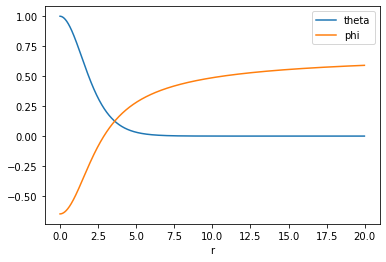

In [76]:
# Plotting best solution
phi0_plt = find_sol()[0]
Xbc_plt = np.array([1, 0, phi0_plt, 0])
Xs, bpoint = rk4(Xbc_plt)

gamma = find_gamma(rinterv, Xs)[0]
print('The value of gamma is:', gamma)

phi0 = find_phi0(Xs, gamma)
print('The value of phi0 is:', phi0)

plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.plot(rinterv[:bpoint], Xs[2].T[:bpoint], label = "phi")
plt.xlabel("r")
plt.legend();

In [35]:
# # Save a high resolution run
# a_file = open("hr_ground.txt", "w")
# for row in Xs:
#     np.savetxt(a_file, row)

# a_file.close()

gamma: -0.6939844753832672 	 gamma (high res): -0.692395413146381 	 percent error: 0.22950213226648214 %
phi0: -1.3434146596178913 	 phi0 (high res): -1.341919373544318 	 percent error: 0.1114289057191196 %


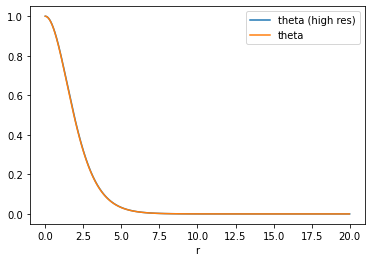

In [86]:
# Comparison with high resolution run
Xs_readflat = np.loadtxt("hr_ground.txt")
rinterv_read = np.linspace(ri, rf, int(len(Xs_readflat)/4), endpoint=True)
Xs_read = Xs_readflat.reshape(4, int(len(Xs_readflat)/4))

gamma_read = find_gamma(rinterv_read, Xs_read)[0]
print('gamma:', gamma, '\t gamma (high res):', gamma_read, '\t percent error:', np.abs((gamma - gamma_read)/gamma_read)*100, '%')

phi0_read = find_phi0(Xs_read, gamma_read)
print('phi0:', phi0, '\t phi0 (high res):', phi0_read,'\t percent error:', np.abs((phi0 - phi0_read)/phi0_read)*100, '%')

plt.plot(rinterv_read, Xs_read[0].T, label = "theta (high res)")
plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], label = "theta")
plt.xlabel("r")
plt.legend();

In [199]:
# # Plotting all solutions
# for phi in phis:
#     phi0_plt = phi
#     Xbc_plt = np.array([1, 0, phi0_plt, 0])

#     Xs = rk4(Xbc_plt)[0]
#     bpoint = rk4(Xbc_plt)[1]
#     plt.plot(rinterv[:bpoint], Xs[0].T[:bpoint], color = 'blue')
# plt.xlabel("r")
# plt.ylabel("theta");